## Overview
A startup company is focusing on various ML solutions for European banking market.

*We want to develop a ML system leveraging call center data to improve the success rate for calls made to customers for the client's products -  
high success rate + interpretability for our clients to make informed decisions.*

**Recent survey data subset:**  

age = age of customer (numeric)  
job = type of job (categorical)  
marital = marital status (categorical)  
education = max education (categorical)  
default = has credit in default? (binary)  
balance = average yearly balance, in euros (numeric)  
housing = has a housing loan? (binary)  
loan = has personal loan? (binary)  
contact = contact communication type (categorical)  
day = last contact day of the month (numeric)  
month = last contact month of year (categorical)  
duration = last contact duration, in seconds (numeric)  
campaign = number of contacts performed during this campaign and for this client (numeric, includes last contact)  

y = has the client subscribed to a term deposit? (binary)

**Goals:**  

*Predict (e.g., >81% accuracy) if a customer will subscribe.* 

*Segment customers based on investment likelihood.*

*Determine features that most determine investment.*  

## Imports

In [62]:
# Standard
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning algorithms
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier, VotingClassifier)
import lightgbm as lgb
from sklearn.cluster import (AgglomerativeClustering, KMeans)
from sklearn.neighbors import KNeighborsClassifier
import scipy.cluster.hierarchy as sch

# For hyperparameter tuning
from sklearn.model_selection import (train_test_split, RandomizedSearchCV, cross_val_score, KFold)
from yellowbrick.model_selection import (validation_curve, learning_curve)

# For implementation
# from sklearn.pipeline import Pipeline
# from sklearn.feature_selection import (SelectFromModel, SelectKBest, chi2)
# from imblearn.over_sampling import (RandomOverSampler, SMOTE)

# For evaluation
from sklearn.metrics import (confusion_matrix, classification_report, f1_score)
from sklearn.metrics import (roc_curve, auc, silhouette_score)

# For quickly testing models
from pycaret.classification import (setup, compare_models)

# Statistics
from scipy import stats
from scipy.stats import yeojohnson

# Feature inspection
from sklearn.inspection import permutation_importance
import shap

## Load data and explore

In [2]:
df = pd.read_csv('marketing.csv')
print('Shape is', df.shape)
df.head(3)

Shape is (40000, 14)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no


In [3]:
df.dtypes

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
y            object
dtype: object

In [4]:
# Are there any nans?

df.isna().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
y            0
dtype: int64

In [5]:
# Create date column (we didn't end up using this)

cols=['month', 'day']
df['date'] = df[cols].apply(lambda x: '-'.join(x.values.astype(str))+'-2021', axis="columns")
df['date']=pd.to_datetime(df['date'])
df['date'].sample(3)

14207   2021-07-11
7235    2021-05-29
1394    2021-05-08
Name: date, dtype: datetime64[ns]

In [6]:
# What are the basic statistics for each feature?

df.describe(include='all').T

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
age,40000.0,NaN,NaN,NaN,NaT,NaT,40.5446,9.641776,19.0,33.0,39.0,48.0,95.0
job,40000,12,blue-collar,9383,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
marital,40000,3,married,24386,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
education,40000,4,secondary,20993,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
default,40000,2,no,39191,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
balance,40000.0,NaN,NaN,NaN,NaT,NaT,1274.27755,2903.769716,-8019.0,54.0,407.0,1319.0,102127.0
housing,40000,2,yes,24031,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
loan,40000,2,no,33070,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
contact,40000,3,cellular,24914,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
day,40000.0,NaN,NaN,NaN,NaT,NaT,16.017225,8.278127,1.0,8.0,17.0,21.0,31.0


Most customers have blue collar jobs, are married, finished secondary school, and presently have a housing loan.

#### Categorical data

In [7]:
# Examine categorical counts for object data grouped by y (invested or not)

# Separate the full dataset into invested (y = yes) and not invested (y = no)
dfy = df[df['y'] == 'yes'].reset_index(drop=True)
dfn = df[df['y'] == 'no'].reset_index(drop=True)

# Column list
cols = df.select_dtypes(include='object').columns

# Create dataframes
# For yes
dfy_counts = dfy[cols[0]].value_counts().reset_index()
dfy_counts.rename(columns={'index': cols[0]+'_ind'}, inplace=True)
# For no
dfn_counts = dfn[cols[0]].value_counts().reset_index()
dfn_counts.rename(columns={'index': cols[0]+'_ind'}, inplace=True)

# Add other columns to dataframe
for c in cols[1:]:
    # For yes
    a = dfy[c].value_counts().reset_index()
    a.rename(columns={'index': c+'_ind'}, inplace=True)
    dfy_counts = pd.concat([dfy_counts, a], axis=1)
    # For no
    b = dfn[c].value_counts().reset_index()
    b.rename(columns={'index': c+'_ind'}, inplace=True)
    dfn_counts = pd.concat([dfn_counts, b], axis=1)

# Divide by total number of yes/no customers
cols = dfy_counts.select_dtypes(include='number').columns
for c in cols:
    dfy_counts[c] = dfy_counts[c]/dfy_counts['y'].max()*100
    dfn_counts[c] = dfn_counts[c]/dfn_counts['y'].max()*100

print('Percentages of Customers who Invested:')
display(dfy_counts.fillna(0).head())
print('\nPercentages of Customers who did not Invest:')
display(dfn_counts.fillna(0).head())

Percentages of Customers who Invested:


,job_ind,job,marital_ind,marital,education_ind,education,default_ind,default,housing_ind,housing,loan_ind,loan,contact_ind,contact,month_ind,month,y_ind,y
0,management,23.342541,married,51.035912,secondary,48.964088,no,98.308011,yes,50.552486,no,86.878453,cellular,77.106354,may,27.313536,yes,100.0
1,blue-collar,18.473757,single,35.462707,tertiary,35.531768,yes,1.691989,no,49.447514,yes,13.121547,unknown,17.161602,apr,15.573204,0,0.0
2,technician,17.161602,divorced,13.501381,primary,12.189227,0,0.000000,0,0.000000,0,0.000000,telephone,5.732044,jul,13.259669,0,0.0
3,admin,12.120166,0,0.000000,unknown,3.314917,0,0.000000,0,0.000000,0,0.000000,0,0.000000,jun,10.151934,0,0.0
4,services,8.218232,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.000000,aug,9.944751,0,0.0



Percentages of Customers who did not Invest:


,job_ind,job,marital_ind,marital,education_ind,education,default_ind,default,housing_ind,housing,loan_ind,loan,contact_ind,contact,month_ind,month,y_ind,y
0,blue-collar,23.846486,married,61.739974,secondary,52.757115,no,97.951703,yes,60.820936,no,82.346917,cellular,61.128180,may,34.338616,no,100.0
1,management,20.186503,single,26.579345,tertiary,27.428310,yes,2.048297,no,39.179064,yes,17.653083,unknown,33.063821,jul,16.159983,0,0.0
2,technician,17.127533,divorced,11.680681,primary,15.947068,0,0.000000,0,0.000000,0,0.000000,telephone,5.807999,aug,13.278892,0,0.0
3,admin,11.136266,0,0.000000,unknown,3.867508,0,0.000000,0,0.000000,0,0.000000,0,0.000000,jun,11.966365,0,0.0
4,services,9.896507,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.000000,nov,9.104140,0,0.0


Now we see the differences in relative populations among investors and noninvestors by feature. Some of the important features (exhibiting clear differences) appear to be job, marital, education, housing loan, and apparently even the contact method.

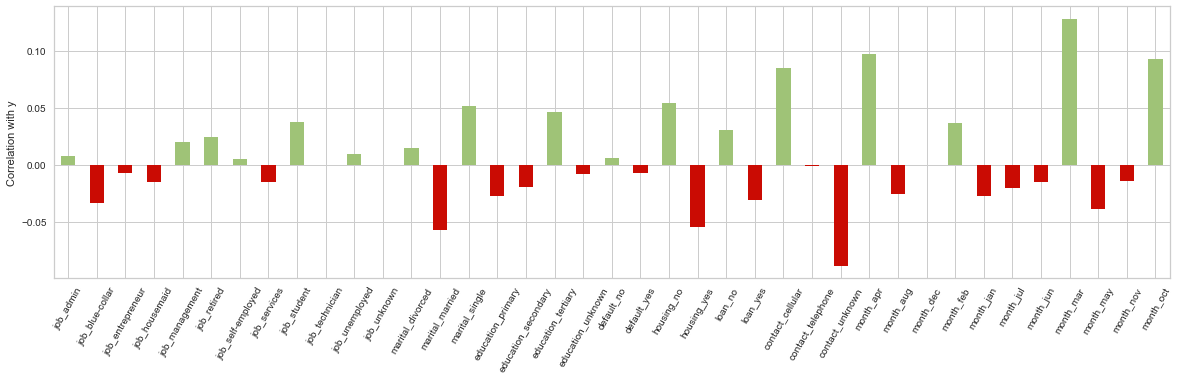

In [8]:
# Make y binary

df1 = df.select_dtypes(include='object').copy()
df1['y'] = df1['y'].map(dict(yes=1, no=0))

# Onehot

df1 = pd.get_dummies(df1, 
                     columns=['job', 
                              'marital', 
                              'education', 
                              'default', 
                              'housing', 
                              'loan', 
                              'contact', 
                              'month'], 
                     drop_first = False)

# Create correlation matrix

corr = df1.corr()

# Series of interest

s = corr['y'].drop('y')

# Plot correlations

plt.figure(figsize=(20,5))
s.plot(kind='bar', color=(s > 0).map({True: 'g', False: 'r'}))
plt.xticks(rotation=60)
plt.xticks(np.arange(len(s)), labels=s.index)
plt.ylabel('Correlation with y')
plt.show()

In [9]:
print('The number of features from the 39 above with correlation coefficient, '
      f'-0.01 < r < 0.01, is {(np.abs(s) < .01).sum()}.')
print()
print('The number of features from the 39 above with correlation coefficient, '
      f'-0.02 < r < 0.02, is {(np.abs(s) < .02).sum()}.')

The number of features from the 39 above with correlation coefficient, -0.01 < r < 0.01, is 11.

The number of features from the 39 above with correlation coefficient, -0.02 < r < 0.02, is 17.


Almost half of the 39 features above show very little correlation with y. Clearly, certain features show much stronger correlations (-0.05 < r < 0.05). One example is the month of March, over against December.

#### Numerical data

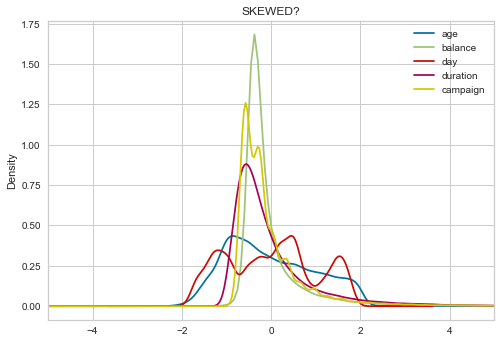

In [10]:
# Examine distributions for numerical data

# Numerical data
dfnum = df.select_dtypes('number')

# Normalize (standard scaler)
for c in dfnum.columns:
    dfnum[c] = (dfnum[c] - dfnum[c].mean())/dfnum[c].std()

# Plot
ax = dfnum.plot(kind='kde', title='SKEWED?')
ax.set_xlim(-5, 5)
plt.show()

In [11]:
# Calculation of feature skewness

skew_vals = dfnum.skew()
skew_vals.sort_values(ascending = False)

balance     8.259236
campaign    4.730901
duration    3.165307
age         0.436080
day         0.067930
dtype: float64

The balance, campaign, and duration are significantly skewed to the right. The age is also positively skewed. The day is roughly normal.

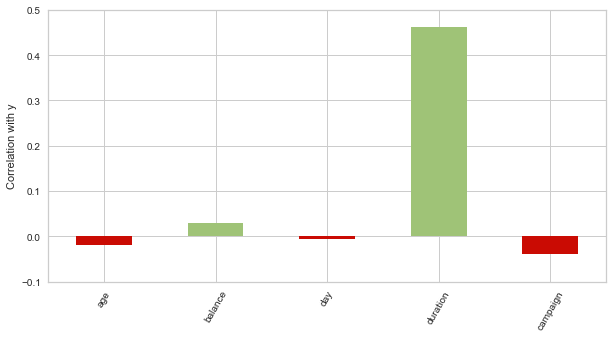

In [12]:
# Correlation matrix

dfnum['y'] = df['y']
dfnum['y'] = dfnum['y'].map(dict(yes=1, no=0))
corr = dfnum.corr()

# Plot correlations

plt.figure(figsize=(10,5))
corr['y'].drop('y').plot(kind='bar', 
                         color=(corr['y'] > 0).map({True: 'g', False: 'r'}))
plt.xticks(rotation=60)
plt.xticks(np.arange(len(corr.index)-1), labels=corr.drop('y').index)
plt.ylabel('Correlation with y')
plt.ylim(-0.1, 0.5)
plt.show()

The weakest correlation with y is the day of the month. Other weakly linked features are age, balance, and campaign.

## Feature Engineering

In [13]:
# Remove onehot variables with low correlation coefficients

# Subset of feature names
cols = list(s[np.abs(s) > .02].index)
# Subset of dataframe
dfcat = df1[cols]
dfcat.head(2)

,job_blue-collar,job_management,job_retired,job_student,marital_married,marital_single,education_primary,education_tertiary,housing_no,housing_yes,loan_no,loan_yes,contact_cellular,contact_unknown,month_apr,month_aug,month_feb,month_jan,month_jul,month_mar,month_may,month_oct
0,0,1,0,0,1,0,0,1,0,1,1,0,0,1,0,0,0,0,0,0,1,0
1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0


Skew:
balance     1.058649
campaign    0.213011
day         0.067930
duration    0.013301
age         0.001901
dtype: float64


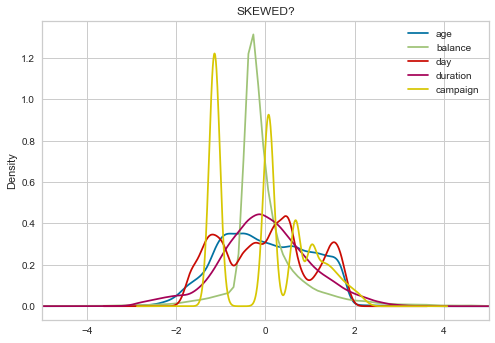

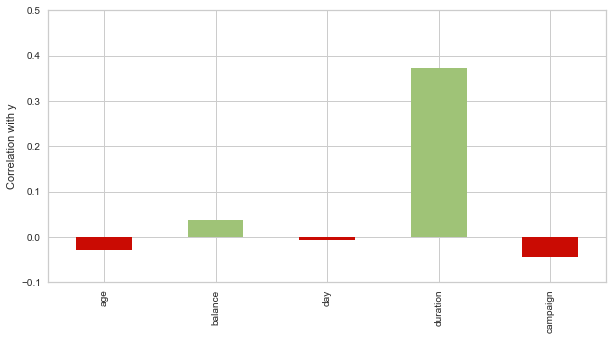

In [14]:
# Remove some skewness of continuous variables via the Yeo Johnson transformation

# Numerical data
dfnum = df.select_dtypes('number')

# Transform and make dataframe
age_tra, age_lambda = yeojohnson(dfnum['age'])
bal_tra, bal_lambda = yeojohnson(dfnum['balance'])
dur_tra, dur_lambda = yeojohnson(dfnum['duration'])
camp_tra, camp_lambda = yeojohnson(dfnum['campaign'])
dfnumy_tra = dfnum.copy()
dfnumy_tra['age'] = age_tra
dfnumy_tra['balance'] = bal_tra
dfnumy_tra['duration'] = dur_tra
dfnumy_tra['campaign'] = camp_tra

# Normalize (standard scaler)
for c in dfnumy_tra.columns:
    dfnumy_tra[c] = (dfnumy_tra[c] - dfnumy_tra[c].mean())/dfnumy_tra[c].std()
    
# Recalculation of feature skewness
skew_vals = dfnumy_tra.skew()
print('Skew:')
print(skew_vals.sort_values(ascending = False))

# Plot distributions for transformed data
ax = dfnumy_tra.plot(kind='kde', title='SKEWED?')
ax.set_xlim(-5, 5)
plt.show()

# Replot correlation matrix
dfnumy_tra['y'] = df['y']
dfnumy_tra['y'] = dfnumy_tra['y'].map(dict(yes=1, no=0))
corr = dfnumy_tra.corr()
plt.figure(figsize=(10,5))
corr['y'].drop('y').plot(kind='bar', 
                         color=(corr['y'] > 0).map({True: 'g', False: 'r'}))
plt.xticks(np.arange(len(corr.index)-1), labels=corr.drop('y').index)
plt.ylabel('Correlation with y')
plt.ylim(-0.1, 0.5)
plt.show()

Weak correlations between y and have improved for age, balance, and campaign.

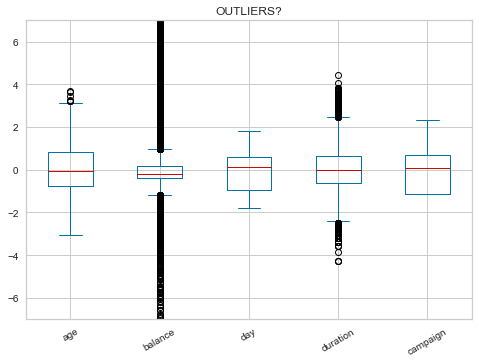

In [15]:
# Are there many outliers in the continuous variables?

dfnumy_tra.iloc[:,:-1].plot(kind='box', title='OUTLIERS?')
plt.xticks(rotation=30)
plt.ylim(-7, 7)
plt.show()

Large number of outliers for balance and duration. However, they are found somewhat symmetrically on either side of the mean. For now, we will keep them.

In [16]:
# Put together final raw dataset

df_raw = pd.concat([dfcat, dfnumy_tra], axis=1, ignore_index=True)
df_raw.columns = list(dfcat.columns) + list(dfnumy_tra.columns)
df_raw.head(2)

,job_blue-collar,job_management,job_retired,job_student,marital_married,marital_single,education_primary,education_tertiary,housing_no,housing_yes,loan_no,loan_yes,contact_cellular,contact_unknown,month_apr,month_aug,month_feb,month_jan,month_jul,month_mar,month_may,month_oct,age,balance,day,duration,campaign,y
0,0,1,0,0,1,0,0,1,0,1,1,0,0,1,0,0,0,0,0,0,1,0,1.625065,0.456660,-1.330884,0.413927,-1.140491,0
1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0,0.463595,-0.387473,-1.330884,-0.189364,-1.140491,0


We have 22 columns of onehot encoded variables, 5 continuous variable, and 1 dependent variable.

## Model exploration

In [17]:
# Set random seed for randomness, here on out
ranseed = 99
np.random.seed(ranseed)

We will use PyCaret on raw and balanced datasets.  

In [18]:
# Although PyCaret will perform a train/test split, we should set aside an
# "official test set" beforehand to facilitate a rigorous evaluation of our final model.
# Thus, PyCaret will be splittng the training set.

# Train, test split of raw data (using 'stratify' due to class imbalance)

yr = df_raw['y'].to_numpy()
Xr = df_raw.iloc[:,:-1].to_numpy()
X_tr_r, X_te_r, y_tr_r, y_te_r = train_test_split(Xr, 
                                                  yr, 
                                                  test_size=0.3, 
                                                  random_state=ranseed, 
                                                  stratify=yr)

In [19]:
# Build dataframe from training set for PyCaret testing of models

df_train_r = pd.DataFrame(X_tr_r, columns=df_raw.columns[:-1])
df_train_r['y'] = y_tr_r
df_train_r.shape

(28000, 28)

In [75]:
# Setup PyCaret and compare models for unbalanced dataset
s = setup(df_train_r, 
          target='y',
          fix_imbalance=True, 
          html=False, 
          silent=True, 
          verbose=False)
best = compare_models()
print(best)

RuntimeError: This version of PyCaret requires scikit-learn==0.23.2, got 1.0.2. Support for newer scikit-learn versions will be added in a future release.

#### Based on running this prior to updating sklearn...
Nothing beats the accuracy of the Dummy classifier. We will try fixing imbalance on our own and trying PyCaret again.

In [21]:
# Create 2, class-specific dataframes

df_invest = df_train_r[df_train_r['y'] == 1].reset_index(drop=True)
df_notinvest = df_train_r[df_train_r['y'] == 0].reset_index(drop=True)

print(f'In the training set, there are {len(df_invest)} investors and {len(df_notinvest)} that did not invest.')

In the training set, there are 2027 investors and 25973 that did not invest.


In [22]:
# We will first try random downsampling (without replacement) 
# to match the class sizes of the noninvestors and investors. 

df_notinvest_s = df_notinvest.sample(n=len(df_invest), random_state=ranseed)

# Combine classes for our small dataframe

df_small = pd.concat([df_invest, df_notinvest_s], axis=0).reset_index(drop=True)
df_small.shape

(4054, 28)

In [23]:
# We will also try random upsampling (with replacement)
# to match the class sizes.

df_invest_s = df_invest.sample(n=len(df_notinvest), replace=True, random_state=ranseed)

# Combine classes for our large dataframe

df_large = pd.concat([df_invest_s, df_notinvest], axis=0).reset_index(drop=True)
df_large.shape

(51946, 28)

In [24]:
# Small balanced dataset
ysm = df_small['y'].to_numpy()
Xsm = df_small.iloc[:,:-1].to_numpy()

# Large balanced dataset
yla = df_large['y'].to_numpy()
Xla = df_large.iloc[:,:-1].to_numpy()

In [25]:
# Setup PyCaret and compare models for small balanced dataset
s = setup(df_small, 
          target='y', 
          html=False, 
          silent=True, 
          verbose=False)
best = compare_models()
print(best)

RuntimeError: This version of PyCaret requires scikit-learn==0.23.2, got 1.0.2. Support for newer scikit-learn versions will be added in a future release.

In [26]:
# Setup PyCaret and compare models for large balanced dataset
s = setup(df_large, 
          target='y', 
          html=False, 
          silent=True, 
          verbose=False)
best = compare_models()
print(best)

RuntimeError: This version of PyCaret requires scikit-learn==0.23.2, got 1.0.2. Support for newer scikit-learn versions will be added in a future release.

#### Based on running this prior to updating sklearn...
The large dataset yields much higher scores.  
Now let's explore the Extra Trees, Random Forest, Light GBM, and K Neighbors classifiers. We will focus on just a few of the key hyperparameters.

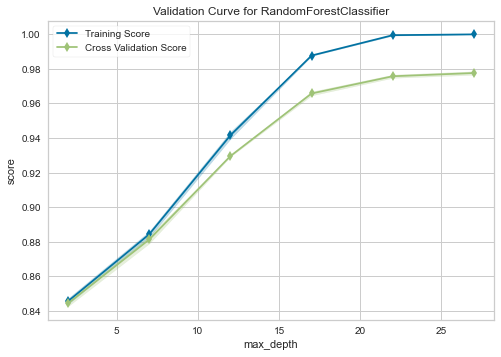

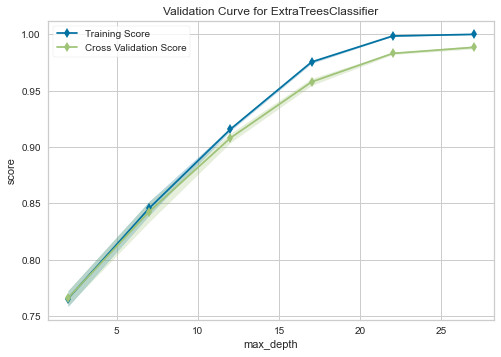

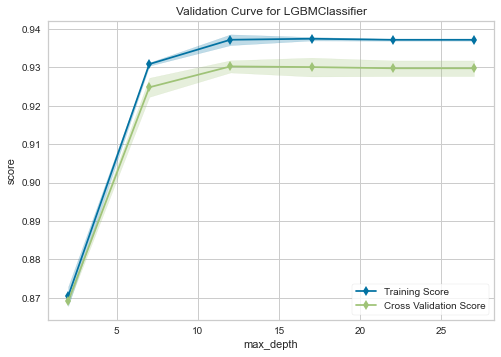

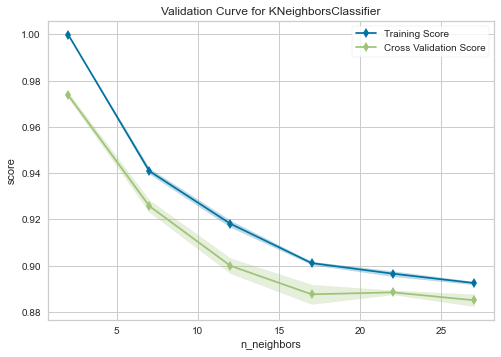

In [30]:
# Define dataset
Xcv = Xla
ycv = yla

# Plot the validation curves for max_depth (trees) and n_neighbors (knn)

rfc_la = RandomForestClassifier(random_state=ranseed)
viz = validation_curve(rfc_la, Xcv, ycv, 
                       param_name='max_depth', n_jobs=-1,
                       param_range=np.arange(2, 30, 5), cv=3, 
                       scoring='f1_macro')

etc_la = ExtraTreesClassifier(random_state=ranseed)
viz = validation_curve(etc_la, Xcv, ycv, 
                       param_name='max_depth', n_jobs=-1,
                       param_range=np.arange(2, 30, 5), cv=3, 
                       scoring='f1_macro')

lgbm_la = lgb.LGBMClassifier(random_state=ranseed)
viz = validation_curve(lgbm_la, Xcv, ycv, 
                       param_name='max_depth', n_jobs=-1,
                       param_range=np.arange(2, 30, 5), cv=3, 
                       scoring='f1_macro')

knn_la = KNeighborsClassifier()
viz = validation_curve(knn_la, Xcv, ycv, 
                       param_name='n_neighbors', n_jobs=-1,
                       param_range=np.arange(2, 30, 5), cv=3, 
                       scoring='f1_macro')

Best parameter values are not the defaults

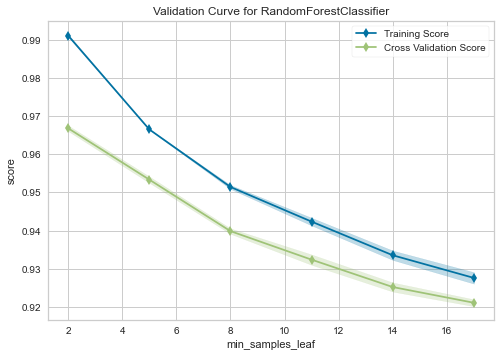

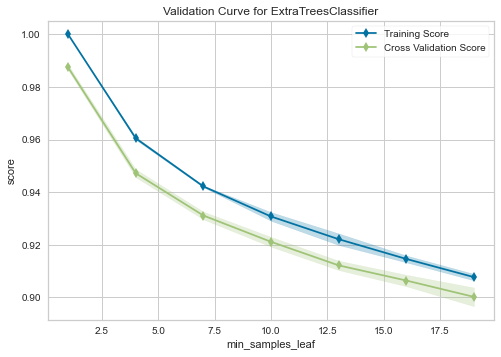

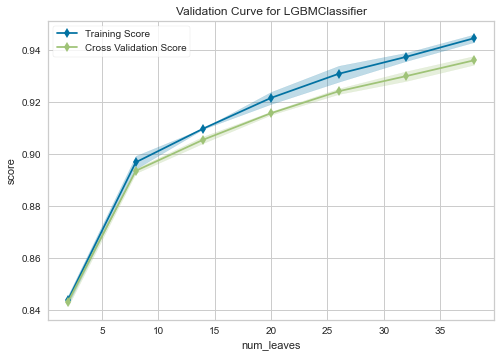

In [31]:
# Set approximate best parameters from above
md_rf_et = 25
md_lgbm = 13
nn = 2

# Plot the validation curves for 'secondary' hyperparameters

rfc_la = RandomForestClassifier(max_depth=md_rf_et, random_state=ranseed)
viz = validation_curve(rfc_la, Xcv, ycv, 
                       param_name='min_samples_leaf', n_jobs=-1,
                       param_range=np.arange(2, 20, 3), cv=3, 
                       scoring='f1_macro')

etc_la = ExtraTreesClassifier(max_depth=md_rf_et, random_state=ranseed)
viz = validation_curve(etc_la, Xcv, ycv, 
                       param_name='min_samples_leaf', n_jobs=-1,
                       param_range=np.arange(1, 20, 3), cv=3, 
                       scoring='f1_macro')

lgbm_la = lgb.LGBMClassifier(max_depth=md_lgbm, random_state=ranseed)
viz = validation_curve(lgbm_la, Xcv, ycv, 
                       param_name='num_leaves', n_jobs=-1,
                       param_range=np.arange(2, 40, 6), cv=3, 
                       scoring='f1_macro')

Default parameter values are best for RFC and ETC

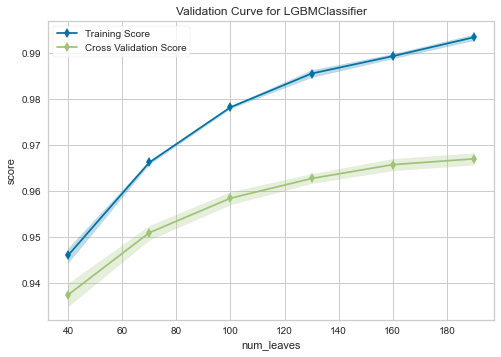

In [32]:
# Check higher leaf counts

lgbm_la = lgb.LGBMClassifier(max_depth=md_lgbm, random_state=ranseed)
viz = validation_curve(lgbm_la, Xcv, ycv, 
                       param_name='num_leaves', n_jobs=-1,
                       param_range=np.arange(40, 200, 30), cv=3, 
                       scoring='f1_macro')

Best value is not default

In [33]:
# Set best (nondefault) parameters from above
nl = 200

All tuned classifiers yield f1 scores close to 0.97. Perhaps combining one or more tree-based models with the very different K Neighbors in a Voting Classifier will work well.

## Modeling

In [34]:
kfold = KFold(n_splits=5, shuffle=True, random_state=ranseed)

rfc_kf = RandomForestClassifier(max_depth=md_rf_et, random_state=ranseed)

rfc_result = cross_val_score(estimator=rfc_kf, 
                         X=Xla, 
                         y=yla, 
                         cv=kfold, 
                         scoring='f1_macro')

print('The average macro f1 during 5-fold cross-validation of Random Forest is '
      f'{100*np.mean(rfc_result):.4}% +/- {100*np.std(rfc_result):.2}%.')

The average macro f1 during 5-fold cross-validation of Random Forest is 98.03% +/- 0.17%.


In [35]:
etc_kf = ExtraTreesClassifier(max_depth=md_rf_et, random_state=ranseed)

etc_result = cross_val_score(estimator=etc_kf, 
                         X=Xla, 
                         y=yla, 
                         cv=kfold, 
                         scoring='f1_macro')

print('The average macro f1 during 5-fold cross-validation of Extra Trees is '
      f'{100*np.mean(etc_result):.4}% +/- {100*np.std(etc_result):.2}%.')

The average macro f1 during 5-fold cross-validation of Extra Trees is 98.96% +/- 0.05%.


In [36]:
lgbm_kf = lgb.LGBMClassifier(max_depth=md_lgbm, num_leaves=nl, random_state=ranseed)

lgbm_result = cross_val_score(estimator=lgbm_kf, 
                         X=Xla, 
                         y=yla, 
                         cv=kfold, 
                         scoring='f1_macro')

print('The average macro f1 during 5-fold cross-validation of LightGBM is '
      f'{100*np.mean(lgbm_result):.4}% +/- {100*np.std(lgbm_result):.2}%.')

The average macro f1 during 5-fold cross-validation of LightGBM is 96.87% +/- 0.23%.


In [37]:
knn_kf = KNeighborsClassifier(n_neighbors=nn)

knn_result = cross_val_score(estimator=knn_kf, 
                         X=Xla, 
                         y=yla, 
                         cv=kfold, 
                         scoring='f1_macro')

print('The average macro f1 during 5-fold cross-validation of LightGBM is '
      f'{100*np.mean(knn_result):.4}% +/- {100*np.std(knn_result):.2}%.')

The average macro f1 during 5-fold cross-validation of LightGBM is 97.72% +/- 0.21%.


All 4 look promising. Let's check each with the test set.

In [38]:
# Fit Random Forest
rfc_kf.fit(Xla, yla)

# Predict

rfc_pred = rfc_kf.predict(X_te_r)

# Classification report

print(classification_report(y_te_r, rfc_pred))

# Confusion matrix

confusion_matrix = pd.crosstab(y_te_r, 
                               rfc_pred, 
                               rownames=['Actual'], 
                               colnames=['Predicted'])
confusion_matrix

              precision    recall  f1-score   support

           0       0.96      0.97      0.96     11131
           1       0.53      0.46      0.49       869

    accuracy                           0.93     12000
   macro avg       0.74      0.71      0.73     12000
weighted avg       0.93      0.93      0.93     12000



Predicted,0,1
Actual,,
0,10778,353
1,469,400


In [39]:
# Fit Extra Trees
etc_kf.fit(Xla, yla)

# Predict

etc_pred = etc_kf.predict(X_te_r)

# Classification report

print(classification_report(y_te_r, etc_pred))

# Confusion matrix

confusion_matrix = pd.crosstab(y_te_r, 
                               etc_pred, 
                               rownames=['Actual'], 
                               colnames=['Predicted'])
confusion_matrix

              precision    recall  f1-score   support

           0       0.95      0.98      0.96     11131
           1       0.56      0.29      0.38       869

    accuracy                           0.93     12000
   macro avg       0.75      0.63      0.67     12000
weighted avg       0.92      0.93      0.92     12000



Predicted,0,1
Actual,,
0,10935,196
1,620,249


In [40]:
# Fit LightGBM
lgbm_kf.fit(Xla, yla)

# Predict

lgbm_pred = lgbm_kf.predict(X_te_r)

# Classification report

print(classification_report(y_te_r, lgbm_pred))

# Confusion matrix

confusion_matrix = pd.crosstab(y_te_r, 
                               lgbm_pred, 
                               rownames=['Actual'], 
                               colnames=['Predicted'])
confusion_matrix

              precision    recall  f1-score   support

           0       0.97      0.94      0.96     11131
           1       0.46      0.67      0.54       869

    accuracy                           0.92     12000
   macro avg       0.72      0.80      0.75     12000
weighted avg       0.94      0.92      0.93     12000



Predicted,0,1
Actual,,
0,10441,690
1,287,582


In [41]:
# Fit KNeighbors
knn_kf.fit(Xla, yla)

# Predict

knn_pred = knn_kf.predict(X_te_r)

# Classification report

print(classification_report(y_te_r, knn_pred))

# Confusion matrix

confusion_matrix = pd.crosstab(y_te_r, 
                               knn_pred, 
                               rownames=['Actual'], 
                               colnames=['Predicted'])
confusion_matrix

              precision    recall  f1-score   support

           0       0.95      0.96      0.96     11131
           1       0.41      0.33      0.37       869

    accuracy                           0.92     12000
   macro avg       0.68      0.65      0.66     12000
weighted avg       0.91      0.92      0.91     12000



Predicted,0,1
Actual,,
0,10716,415
1,580,289


If we have to choose one, LightGBM is preferred. It gives the highest number of true positives and lowest number of false negatives, which means it outperforms the other algorithms in how few actual investors it misclassifies.

##### Not included here: I tried a Voting Classifier with LGBM, RF, and KN, but at best it reproduced the LGBM results.  


Therefore, we choose the LGBM as our classifier. Below is an ROC curve.

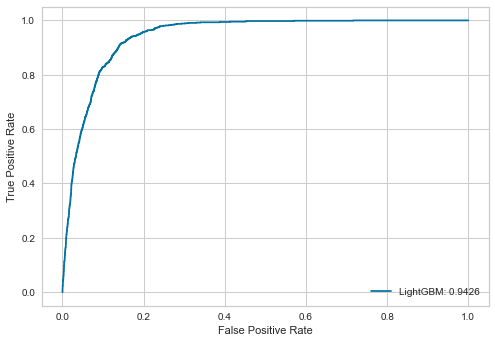

In [42]:
# Predict probabilities for investing

pred_proba = lgbm_kf.predict_proba(X_te_r)[:,1]

# Get the false and true positive rates

fpr, tpr, threshold = roc_curve(y_te_r, pred_proba)

# Area under curve

roc_auc = auc(fpr, tpr)

# Plot ROC curve

plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend([f'LightGBM: {roc_auc:.4}'])
plt.show()

## Feature importance

In [43]:
# Shapely additive explanations

shap.initjs()

# Use this explainer for our tree-based LGBM

explainer = shap.TreeExplainer(lgbm_kf)

# Explain model output for test set

shap_values = explainer.shap_values(X_te_r)

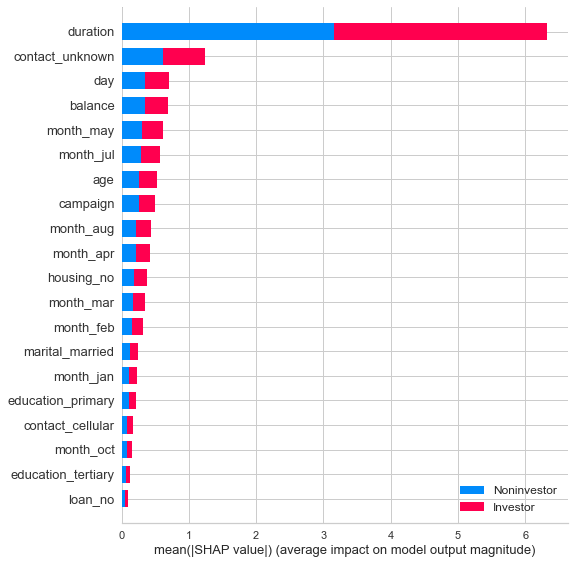

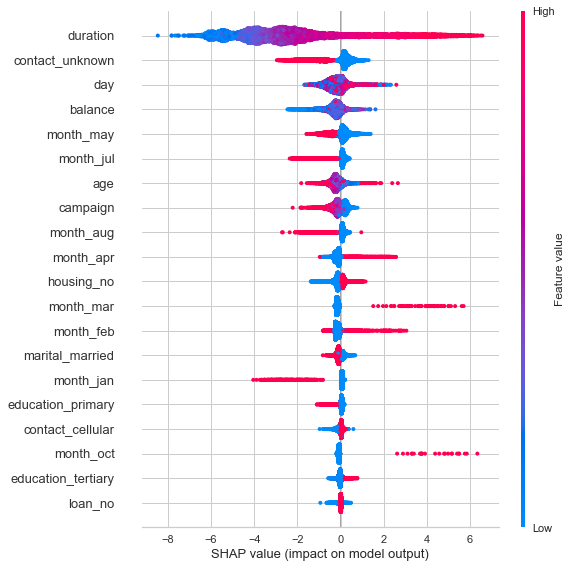

In [44]:
# Summary plot

shap.summary_plot(shap_values, 
                  features=X_te_r, 
                  feature_names=df_large.iloc[:,:-1].columns, 
                  class_names=['Noninvestor', 'Investor'],
                  title='Avg Impact on Model Output', 
                  plot_type='bar')
        
# Summary plot for class 1

shap.summary_plot(shap_values[1], 
                  features=X_te_r, 
                  feature_names=df_large.iloc[:,:-1].columns, 
                  title='Investor Class (plot for noninvestor class is mirror image)')

'Duration' of the last call with the customer, as expected from data exploration (correlation matrix), is the most important feature of the model.

After this comes 'contact_unknown', which is a bad sign for investments.

'Day' of the month comes next with a somewhat surprisingly high feature importance. On a related topic, there appear to be several months during which customers most often choose to invest (e.g., late winter/early spring).

Average yearly 'balance' and 'age' of the customer are also high on the list, which are logical factors to consider. However, their high/low feature values are not well separated. 

It is important to note that a lengthy 'campaign' negatively impacts the outcome.

We will now look at a few examples of false negatives and true positives to see if there are any patterns that might provide us with insights.

In [45]:
# Build dataframe from test set for examining FNs and TPs

df_test_r = pd.DataFrame(X_te_r, columns=df_raw.columns[:-1])
df_test_r['y'] = y_te_r
df_test_r['pred'] = lgbm_pred

# Identify the false negatives (which we want to minimize) and true positives (which we want to maximize)

FNarr = df_test_r[(df_test_r['y'] == 1) & (df_test_r['pred'] == 0)]
TParr = df_test_r[(df_test_r['y'] == 1) & (df_test_r['pred'] == 1)]

In [46]:
FNarr.head()

,job_blue-collar,job_management,job_retired,job_student,marital_married,marital_single,education_primary,education_tertiary,housing_no,housing_yes,loan_no,loan_yes,contact_cellular,contact_unknown,month_apr,month_aug,month_feb,month_jan,month_jul,month_mar,month_may,month_oct,age,balance,day,duration,campaign,y,pred
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.154066,-0.108395,-1.572484,0.314136,-1.140491,1,0
52,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.457923,-0.341190,-0.243681,-0.388507,-1.140491,1,0
56,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.623022,0.079787,-0.364482,0.894868,0.672727,1,0
82,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.382001,-0.140710,-0.968483,0.469466,0.672727,1,0
85,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.044582,3.259299,0.239520,2.297756,0.070961,1,0


In [47]:
TParr.head()

,job_blue-collar,job_management,job_retired,job_student,marital_married,marital_single,education_primary,education_tertiary,housing_no,housing_yes,loan_no,loan_yes,contact_cellular,contact_unknown,month_apr,month_aug,month_feb,month_jan,month_jul,month_mar,month_may,month_oct,age,balance,day,duration,campaign,y,pred
23,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.650730,-0.088988,-1.210083,1.678074,0.070961,1,1
40,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.402081,2.268512,-0.243681,1.864398,0.070961,1,1
68,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.919565,0.023790,1.689123,1.213312,-1.140491,1,1
76,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.477751,0.899629,-0.122881,0.426956,0.070961,1,1
127,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.266486,-0.409972,-1.814085,2.243755,0.070961,1,1


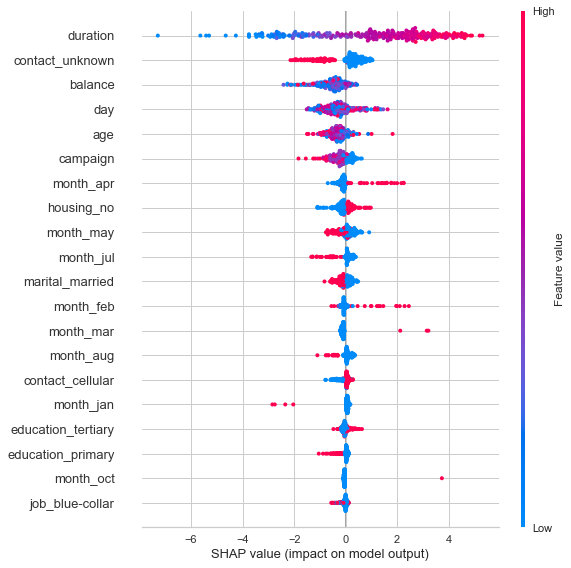

In [48]:
# shap for FN
shap_valFN = explainer.shap_values(FNarr.iloc[:,:-2].to_numpy())

# Summary plot for false negatives
shap.summary_plot(shap_valFN[1], 
                  features=FNarr.iloc[:,:-2].to_numpy(), 
                  feature_names=FNarr.iloc[:,:-2].columns, 
                  title='Investor Class (plot for noninvestor class is mirror image)')

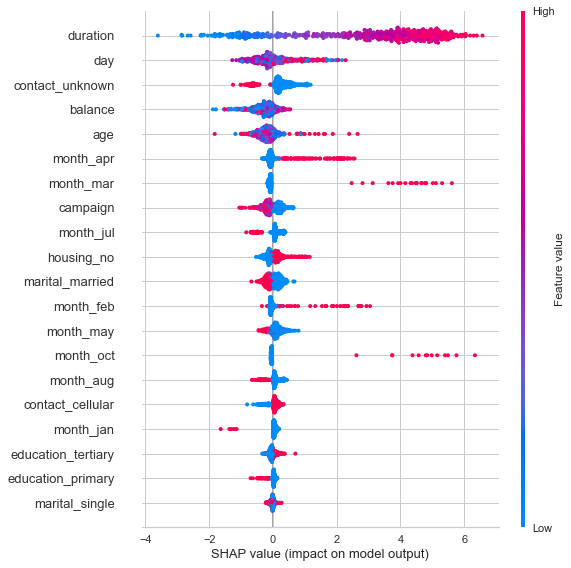

In [49]:
# shap for TP
shap_valTP = explainer.shap_values(TParr.iloc[:,:-2].to_numpy())

# Summary plot for true positives
shap.summary_plot(shap_valTP[1], 
                  features=TParr.iloc[:,:-2].to_numpy(), 
                  feature_names=TParr.iloc[:,:-2].columns, 
                  title='Investor Class (plot for noninvestor class is mirror image)')

There are a few differences in the feature importances between the FNs and TPs:  

1. While 'duration' is at the top in both, small shap values appear to be centered at lower feature values among TPs.  
2. Some important features for TPs rank several places lower for FNs ('day', 'month_mar'), and some less important ones rank higher ('housing_no', 'month_may'). 
3. The 'contact_unknown' for TPs tends to have fewer number of positive values for TPs (i.e., contacts are more often known).
4. The distribution of shap values for 'age' is different.

Although we won't test this here, it may be that removal of some features (that are unimportant overall, or falsely important among the FNs) would improve precision and recall.

## Customer Segmentation

#### Agglomerative Clustering

In [116]:
# Remove some features from investor and noninvestor dataframes

drop_list = ['contact', 'day', 'month', 'duration', 'campaign', 'date']

df_inv = dfy.drop(columns=drop_list)
df_ninv = dfn.drop(columns=drop_list)

# Downsample noninvestor data to match size of investor dataset
# (also saves computation time if we keep dataset small)

df_ninv_s = df_ninv.sample(n=len(df_inv), random_state=ranseed)

# Combine datasets for Agglomerative Clustering

df_AC = pd.concat([df_inv, df_ninv_s], axis=0).reset_index(drop=True)

df_AC.sample(5)

,age,job,marital,education,default,balance,housing,loan,y
1851,56,technician,married,secondary,no,2847,no,no,yes
2829,38,unemployed,single,secondary,no,804,no,no,yes
4994,50,self-employed,married,secondary,no,111,no,no,no
5226,32,services,single,tertiary,no,143,yes,yes,no
2478,31,admin,single,tertiary,no,355,yes,no,yes


In [117]:
# Numeric to categorical for age and balance

df_AC['age_quant'] = pd.cut(df_AC['age'], bins=12, precision=0)
df_AC['balance_quant'] = pd.qcut(df_AC['balance'], q=5, precision=0)

# Make binary truly 0s and 1s

df_AC['default'] = df_AC['default'].map(dict(yes=1, no=0))
df_AC['housing'] = df_AC['housing'].map(dict(yes=1, no=0))
df_AC['loan'] = df_AC['loan'].map(dict(yes=1, no=0))
df_AC['y'] = df_AC['y'].map(dict(yes=1, no=0))

# Onehot and drop the binned columns from earlier step

df_AC = pd.get_dummies(df_AC, 
                     columns=['job', 
                              'marital', 
                              'education', 
                              'age_quant', 
                              'balance_quant'], 
                     drop_first = False).drop(columns=['age', 'balance'])

df_AC.sample(3)

,default,housing,loan,y,job_admin,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown,"age_quant_(19.0, 25.0]","age_quant_(25.0, 32.0]","age_quant_(32.0, 38.0]","age_quant_(38.0, 44.0]","age_quant_(44.0, 51.0]","age_quant_(51.0, 57.0]","age_quant_(57.0, 63.0]","age_quant_(63.0, 70.0]","age_quant_(70.0, 76.0]","age_quant_(76.0, 82.0]","age_quant_(82.0, 89.0]","age_quant_(89.0, 95.0]","balance_quant_(-3059.0, 27.0]","balance_quant_(27.0, 293.0]","balance_quant_(293.0, 756.0]","balance_quant_(756.0, 1956.0]","balance_quant_(1956.0, 56831.0]"
4770,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2069,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
4466,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0


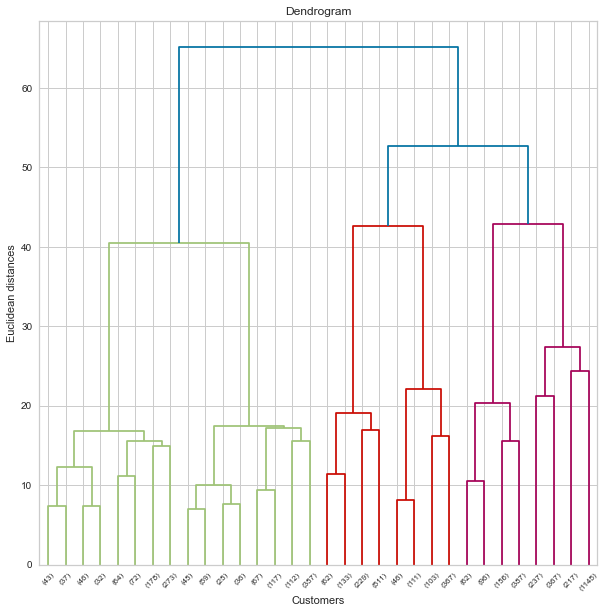

In [118]:
# Dendrogram

plt.figure(figsize=(10,10))
dendrogram = sch.dendrogram(sch.linkage(df_AC, method='ward'), p=4, truncate_mode='level')
plt.title('Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Euclidean distances')
plt.show()

We will assign n_clusters = 6.

In [119]:
# Hierarchical clustering

# AC = AgglomerativeClustering(linkage='ward', compute_distances=True).fit(inv)
AC = AgglomerativeClustering(n_clusters=6, linkage='ward')
y_AC = AC.fit_predict(df_AC.to_numpy())

In [121]:
# Assign cluster column to dataframe

df_AC['cluster'] = y_AC
df_AC.sample(5)

,default,housing,loan,y,job_admin,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown,"age_quant_(19.0, 25.0]","age_quant_(25.0, 32.0]","age_quant_(32.0, 38.0]","age_quant_(38.0, 44.0]","age_quant_(44.0, 51.0]","age_quant_(51.0, 57.0]","age_quant_(57.0, 63.0]","age_quant_(63.0, 70.0]","age_quant_(70.0, 76.0]","age_quant_(76.0, 82.0]","age_quant_(82.0, 89.0]","age_quant_(89.0, 95.0]","balance_quant_(-3059.0, 27.0]","balance_quant_(27.0, 293.0]","balance_quant_(293.0, 756.0]","balance_quant_(756.0, 1956.0]","balance_quant_(1956.0, 56831.0]",cluster
2838,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4664,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,2
2568,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
3513,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2098,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0


In [163]:
# Cluster stats

clust_stat = df_AC.groupby('cluster').sum().T.rename(
    columns={0: 'cluster1', 1: 'cluster2', 2: 'cluster3', 3: 'cluster4', 4: 'cluster5', 5: 'cluster6'})

clust_stat

cluster,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6
default,37.0,16.0,11.0,14.0,25.0,10.0
housing,1140.0,350.0,363.0,433.0,555.0,364.0
loan,351.0,103.0,109.0,103.0,153.0,70.0
y,897.0,338.0,429.0,269.0,505.0,458.0
job_admin,296.0,79.0,31.0,20.0,187.0,44.0
job_blue-collar,523.0,102.0,4.0,418.0,193.0,15.0
job_entrepreneur,65.0,14.0,42.0,24.0,8.0,20.0
job_housemaid,36.0,18.0,6.0,67.0,5.0,11.0
job_management,102.0,158.0,549.0,21.0,27.0,379.0
job_retired,160.0,41.0,17.0,29.0,0.0,1.0


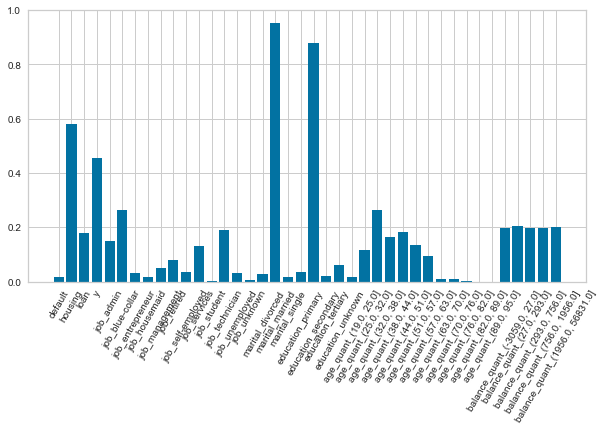

In [162]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(clust_stat.index, clust_stat['cluster1'])
plt.xticks(rotation=60)
plt.show()

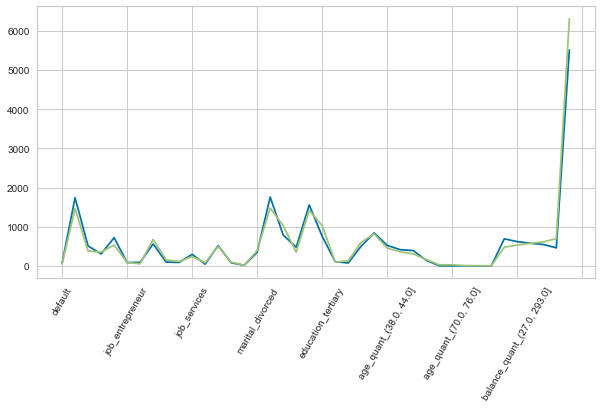

In [160]:
# Categorical stats by investor/noninvestor

dfmisc = df_AC.groupby('y').sum().T
dfmisc['percdiff'] = np.round((dfmisc[1] - dfmisc[0]) / dfmisc[0] * 100, 1)
# dfmisc
df_AC.groupby('y').mean().T
dfmisc[0].plot(figsize=(15, 5))
dfmisc[1].plot(figsize=(15, 5))
plt.xticks(rotation=60)
plt.show()

In [158]:
dfmisc[0]


default                              64.0
housing                            1741.0
loan                                509.0
job_admin                           306.0
job_blue-collar                     720.0
job_entrepreneur                     85.0
job_housemaid                        90.0
job_management                      560.0
job_retired                          97.0
job_self-employed                    88.0
job_services                        295.0
job_student                          44.0
job_technician                      517.0
job_unemployed                       80.0
job_unknown                          14.0
marital_divorced                    348.0
marital_married                    1759.0
marital_single                      789.0
education_primary                   476.0
education_secondary                1557.0
education_tertiary                  756.0
education_unknown                   107.0
age_quant_(19.0, 25.0]               74.0
age_quant_(25.0, 32.0]            

In [137]:
.mean().T.rename(
    columns={0: 'cluster1', 1: 'cluster2', 2: 'cluster3', 3: 'cluster4', 4: 'cluster5', 5: 'cluster6'})

clust_stat

,default,housing,loan,y,job_admin,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown,"age_quant_(19.0, 25.0]","age_quant_(25.0, 32.0]","age_quant_(32.0, 38.0]","age_quant_(38.0, 44.0]","age_quant_(44.0, 51.0]","age_quant_(51.0, 57.0]","age_quant_(57.0, 63.0]","age_quant_(63.0, 70.0]","age_quant_(70.0, 76.0]","age_quant_(76.0, 82.0]","age_quant_(82.0, 89.0]","age_quant_(89.0, 95.0]","balance_quant_(-3059.0, 27.0]","balance_quant_(27.0, 293.0]","balance_quant_(293.0, 756.0]","balance_quant_(756.0, 1956.0]","balance_quant_(1956.0, 56831.0]",cluster
0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
2,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
4,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,2


## Conclusion

We used a Light Gradient Boosting Classifier to achieve an accuracy of 99%, with F1-scores of 0.99 for both classes. 

The most impactful features were the...